在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

Inception块由四条并行路径组成。 前三条路径使用窗口大小为1x1、3x3和5x5的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行1x1卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用3x3最大汇聚层，然后使用1x1卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

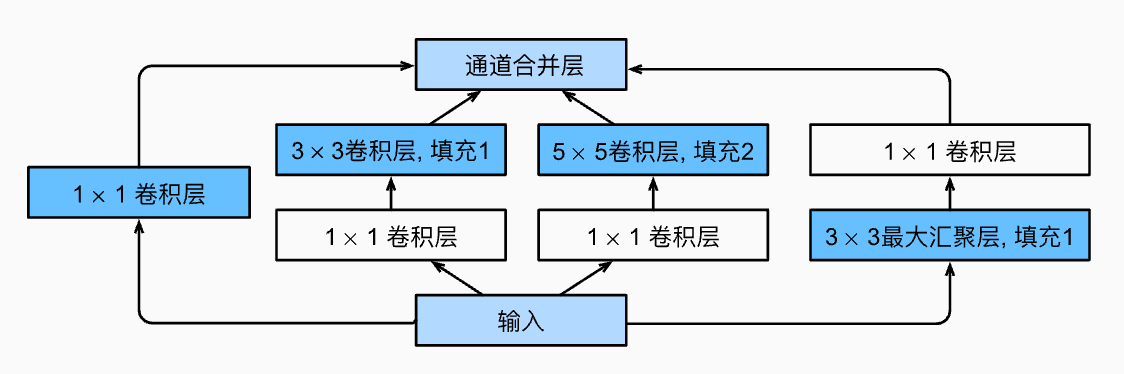

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

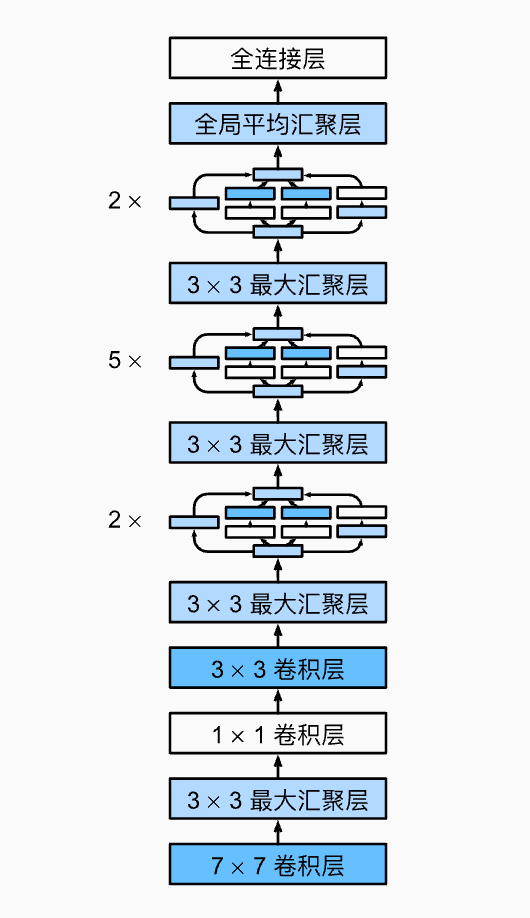

In [ ]:
import torch
from torch import nn
import sys
sys.path.append('..')
from torch.nn import functional as F
from tools import tool_pytorch_017 as ty

# 构建Inception
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)
    
# 第一个模块使用64个通道、7x7卷积层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第二个模块使用两个卷积层：第一个卷积层是64个通道、1x1卷积层；第二个卷积层使用将通道数量增加三倍的3x3卷积层。 
# 这对应于Inception块中的第二条路径。
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第三个模块串联两个完整的Inception块。
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 第四模块更加复杂， 它串联了5个Inception块，这些路径的通道数分配和第三模块中的类似.
# 首先是含3x3卷积层的第二条路径输出最多通道，其次是仅含1x1卷积层的第一条路径，之后是含5x5卷积层的第三条路径和含3x3最大汇聚层的第四条路径。 
# 其中第二、第三条路径都会先按比例减小通道数。 
# 这些比例在各个Inception块中都略有不同。
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# 第五模块包含两个Inception块。 
# 其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。 
# 需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。 
# 最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
    
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = ty.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(ty.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


#@save
def train_AlexNet(net, train_iter, test_iter, num_epochs, lr, device):
    """训练AlexNet模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = ty.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = ty.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = ty.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], ty.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = ty.load_data_fashion_mnist(batch_size, resize=96)
train_AlexNet(net, train_iter, test_iter, num_epochs, lr, ty.try_gpu())